In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets
import torchvision.transforms as transforms

print(torch.cuda.is_available())
     

True


In [2]:
!pip install tensorboard

In [3]:
from torch.utils.tensorboard import SummaryWriter

In [4]:
import matplotlib.pyplot as plt

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
     

class Discriminator(nn.Module):
  def __init__(self,input_shape:int):
    super().__init__()
    self.conv_layer=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=512,out_channels=1,kernel_size=4,stride=1,padding=0,bias=False),
        nn.Sigmoid()


    )

  def forward(self,x):
    return self.conv_layer(x)

     

class Generator(nn.Module):
  def __init__(self,z_dim:int,img_channels):
    super().__init__()
    self.trans_conv_layer=nn.Sequential(
        nn.ConvTranspose2d(in_channels=z_dim,out_channels=512,kernel_size=4,stride=1,padding=0,bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=64,out_channels=img_channels,kernel_size=4,stride=2,padding=1,bias=False),
        nn.Tanh()


    )

  def forward(self,x):
    return self.trans_conv_layer(x)



In [6]:

device="cuda" if torch.cuda.is_available() else "cpu"
n_c=3

gen=Generator(z_dim=100,img_channels=n_c).to(device)
gen.apply(weights_init)

disc=Discriminator(input_shape=n_c).to(device)
disc.apply(weights_init)

Discriminator(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [7]:
# training params
batch_size=128
lr=0.0002
z_dim=100
img_size=64
n_c=3

transform=transforms.Compose(transforms=[transforms.ToTensor(),
                                         transforms.Resize((64,64)),
                                         transforms.Normalize([0.5 for _ in range(n_c)],[0.5 for _ in range(n_c)])])
dataset=datasets.CIFAR10(root="data",transform=transform,download=True)
data_loader=DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True)




Files already downloaded and verified


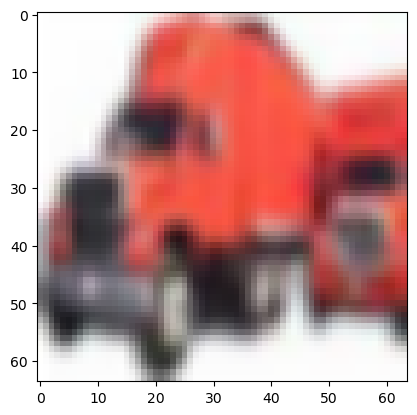

In [8]:
image,label=next(iter(data_loader))
import matplotlib.pyplot as plt
plt.imshow((image[0]*0.5+0.5).permute(1,2,0))
plt.show()

In [9]:
loss_fn=nn.BCELoss()
optimizer_disc=torch.optim.Adam(params=disc.parameters(),lr=lr,betas=(0.5,0.999))
optimizer_gen=torch.optim.Adam(params=gen.parameters(),lr=lr,betas=(0.5,0.999))
     

writer_fake=SummaryWriter(f"runs/GAN_MNIST/fake")

writer_real=SummaryWriter(f"runs/GAN_MNIST/real")

step = 0

fixed_noise = torch.randn(size=(64,z_dim,1,1))
     

# z=torch.rand(size=(1,100,1,1))
# z.shape
     

# img,label=next(iter(data_loader))
# img.shape
     


In [10]:
!pip install torchinfo

In [11]:
from torchinfo import summary

summary(disc,input_size=[1,3,64,64])

# disc.eval()
# with torch.inference_mode():
#   print(disc(torch.rand(size=(1,1,64,64)).to('cuda')).shape)

     

# disc.eval()
# with torch.inference_mode():
#   print(disc(torch.rand(size=(1,1,64,64)).to('cuda')).shape)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1, 1, 1]              --
├─Sequential: 1-1                        [1, 1, 1, 1]              --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           3,072
│    └─LeakyReLU: 2-2                    [1, 64, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 128, 16, 16]          131,072
│    └─BatchNorm2d: 2-4                  [1, 128, 16, 16]          256
│    └─LeakyReLU: 2-5                    [1, 128, 16, 16]          --
│    └─Conv2d: 2-6                       [1, 256, 8, 8]            524,288
│    └─BatchNorm2d: 2-7                  [1, 256, 8, 8]            512
│    └─LeakyReLU: 2-8                    [1, 256, 8, 8]            --
│    └─Conv2d: 2-9                       [1, 512, 4, 4]            2,097,152
│    └─BatchNorm2d: 2-10                 [1, 512, 4, 4]            1,024
│    └─LeakyReLU: 2-11                   [1, 512, 4, 4]     

In [12]:
summary(gen,input_size=[1,100,1,1])

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 3, 64, 64]            --
├─Sequential: 1-1                        [1, 3, 64, 64]            --
│    └─ConvTranspose2d: 2-1              [1, 512, 4, 4]            819,200
│    └─BatchNorm2d: 2-2                  [1, 512, 4, 4]            1,024
│    └─ReLU: 2-3                         [1, 512, 4, 4]            --
│    └─ConvTranspose2d: 2-4              [1, 256, 8, 8]            2,097,152
│    └─BatchNorm2d: 2-5                  [1, 256, 8, 8]            512
│    └─ReLU: 2-6                         [1, 256, 8, 8]            --
│    └─ConvTranspose2d: 2-7              [1, 128, 16, 16]          524,288
│    └─BatchNorm2d: 2-8                  [1, 128, 16, 16]          256
│    └─ReLU: 2-9                         [1, 128, 16, 16]          --
│    └─ConvTranspose2d: 2-10             [1, 64, 32, 32]           131,072
│    └─BatchNorm2d: 2-11                 [1, 64, 32, 32]  

In [13]:
!pip install tqdm

In [14]:
from tqdm.auto import tqdm

epochs=500
loss_d=[]
loss_g=[]

for epoch in tqdm(range(epochs)):
  for batch_idx,(x,_) in enumerate(data_loader):
    z=torch.randn(size=(batch_size,100,1,1),device=device)

    ## traing the discriminator

    disc.zero_grad()
    disc_real=disc(x.to('cuda')).reshape(-1)
    loss_disc_real=loss_fn(disc_real,torch.ones_like(disc_real))
    loss_disc_real.backward()


    fake=gen(z.to('cuda'))
    disc_fake=disc(fake.detach().to('cuda')).reshape(-1)
    loss_disc_fake=loss_fn(disc_fake,torch.zeros_like(disc_fake))
    loss_disc_fake.backward()

    loss_disc=loss_disc_fake+loss_disc_real
    loss_d.append(loss_disc.item())

    optimizer_disc.step()

    #training generator
    gen.zero_grad()

    fool_logits=disc(fake.to('cuda')).reshape(-1)
    loss_gen=loss_fn(fool_logits,torch.ones_like(fool_logits))
    loss_g.append(loss_gen.item())

    loss_gen.backward()

    optimizer_gen.step()

    if batch_idx%200 == 0:
            print(
                f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(data_loader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise.to('cuda')).detach()
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(x[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [0/500] Batch 0/391                   Loss D: 1.7522, loss G: 4.8476
Epoch [0/500] Batch 200/391                   Loss D: 0.1787, loss G: 5.4102
Epoch [1/500] Batch 0/391                   Loss D: 0.1465, loss G: 5.0960
Epoch [1/500] Batch 200/391                   Loss D: 0.1943, loss G: 6.0847
Epoch [2/500] Batch 0/391                   Loss D: 0.8767, loss G: 5.2001
Epoch [2/500] Batch 200/391                   Loss D: 0.8014, loss G: 7.2198
Epoch [3/500] Batch 0/391                   Loss D: 0.4551, loss G: 4.6679
Epoch [3/500] Batch 200/391                   Loss D: 0.4013, loss G: 2.9919
Epoch [4/500] Batch 0/391                   Loss D: 1.0323, loss G: 1.5471
Epoch [4/500] Batch 200/391                   Loss D: 0.5343, loss G: 3.6553
Epoch [5/500] Batch 0/391                   Loss D: 0.5448, loss G: 2.5459
Epoch [5/500] Batch 200/391                   Loss D: 0.9674, loss G: 1.2945
Epoch [6/500] Batch 0/391                   Loss D: 0.5409, loss G: 3.3464
Epoch [6/500]

In [15]:
!nvidia-smi

Sat Sep 21 05:08:07 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.09                 Driver Version: 561.09         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   79C    P0             80W /   86W |    1845MiB /   8188MiB |     66%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [19]:
%load_ext tensorboard
%tensorboard --logdir="runs"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 10272), started 6:21:48 ago. (Use '!kill 10272' to kill it.)

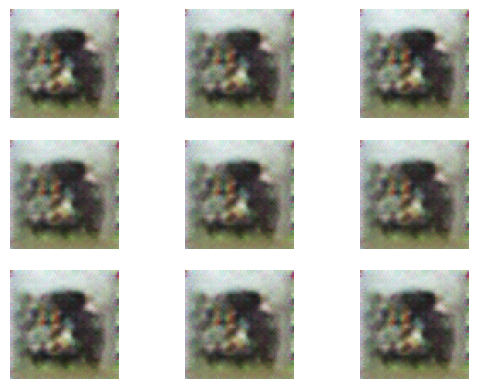

In [17]:
noise=torch.rand(size=(batch_size,z_dim,1,1)).to(device)
gen_img=gen(noise)
     

with torch.inference_mode():
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow((gen_img[i]*0.5+0.5).cpu().permute(1,2,0))
    plt.axis(False)

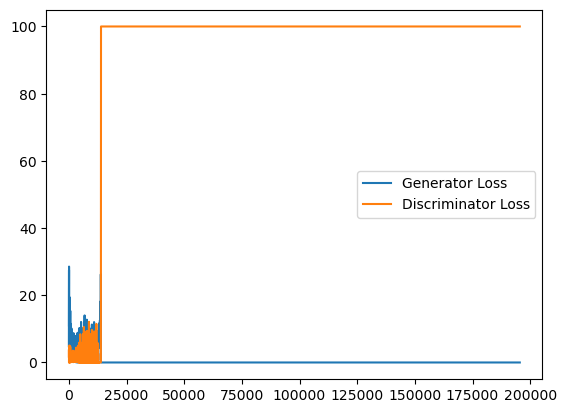

In [18]:
plt.plot(loss_g,label="Generator Loss")
plt.plot(loss_d,label="Discriminator Loss")
plt.legend()
plt.show()
     
